# ECCOv4 Loading llc binary files in the 'compact' format

This section demonstrates loading ECCO binary files written in the so-called llc 'compact' format. Compact binary files have a non-intuitive layout of the 13 lat-lon-cap tiles required by the MITgcm.  This tutorial demonstrates using the 'read_llc_to_tiles' routine to read and re-organize the llc compact binary files into a more familiar 13-tile layout.

## Objectives

By the end of the tutorial you will be able to read llc compact binary files of any dimension, plot them, and convert them into DataArrays.

In [1]:
## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  For example, if your ecco_v4_py
##    files are in /Users/ifenty/ECCOv4-py/ecco_v4_py, then use:
import sys
sys.path.append('/Users/ifenty/ECCOv4-py')
import ecco_v4_py as ecco

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## The *read_llc_to_tiles* subroutine

*read_llc_to_tiles* reads a llc compact format binary file and converts to a numpy ndarray of dimension:
[N_recs, N_z, N_tiles, llc, llc]

For ECCOv4 our convenction is:
```
'N_recs' = number of time cords
'N_z' = number of depth levels
'N_tiles' = 13
'llc' = 90
```

By default the routine will try to load a single 2D slice of a llc90 compact binary file: (N_rec = 1, N_z =1, N_tiles = 13, and llc=90).  

There are several other options which you can learn about using the 'help' command:

In [2]:
help(ecco.read_llc_to_tiles)

Help on function read_llc_to_tiles in module ecco_v4_py.read_bin_llc:

read_llc_to_tiles(fdir, fname, llc=90, skip=0, nk=1, nl=1, filetype='>f', less_output=False, use_xmitgcm=False)
    Loads an MITgcm binary file in the 'tiled' format of the 
    lat-lon-cap (LLC) grids with dimension order:
    
        [N_recs, N_z, N_tiles, llc, llc]
    
    where if either N_z or N_recs =1, then that dimension is collapsed
    and not present in the returned array.
    
    if use_xmitgcm == True
    
        data are read in via the low level routine 
        xmitgcm.utils.read_3d_llc_data and returned as dask array.
    
        Hint: use data_tiles.compute() to load into memory.
    
    if use_xmitgcm == False
    
        Loads an MITgcm binary file in the 'compact' format of the 
        lat-lon-cap (LLC) grids and converts it to the '13 tiles' format
        of the LLC grids.  
    
    Parameters
    ----------
    fdir : string
        A string with the directory of the binary file to o

## Related routines

Two related routines which you might find useful: 

1. *read_llc_to_compact*: Loads an MITgcm binary file in the 'compact' format of the 
    lat-lon-cap (LLC) grids and preserves its original dimension
    
2.  *read_llc_to_faces* : Loads an MITgcm binary file in the 'compact' format of the 
    lat-lon-cap (LLC) grids and converts it to the '5 faces' dictionary. 
    
For the remainder of the tutorial we will only use *read_llc_to_tiles*.

## Example 1: Load a 2D llc 'compact' binary file

First load the bathymetry map

In [3]:
input_dir = '/Users/ifenty/tmp/input_init/'
input_file = 'bathy_eccollc_90x50_min2pts.bin'

In [4]:
bathy = ecco.read_llc_to_tiles(input_dir, input_file)

loading  bathy_eccollc_90x50_min2pts.bin
data shape  (1170, 90)
dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)
data_tiles shape  (13, 90, 90)
data_tiles shape =  (13, 90, 90)


*bathy* is a float64 numpy array of dimension [13, 90, 90]

In [5]:
print(bathy.shape)
print(type(bathy))
print(type(bathy[0,0,0]))

(13, 90, 90)
<class 'numpy.ndarray'>
<class 'numpy.float64'>


### Plot the 13 tiles

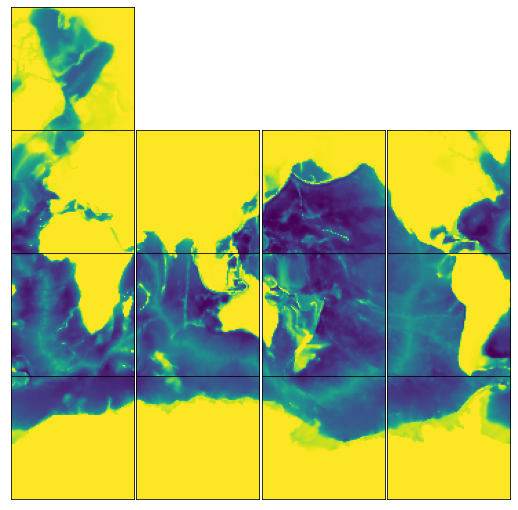

In [6]:
# Use plot_tiles to make a quick plot of the 13 tiles.  See the tutorial on plotting for more examples.
ecco.plot_tiles(bathy, layout='latlon',rotate_to_latlon=True,show_tile_labels=False);

## Load ecco-grid information to make a fancier lat-lon plot

In [7]:
ecco_grid_dir = '/Users/ifenty/tmp/nctiles_grid/'
ecco_grid = ecco.load_ecco_grid_nc(input_dir, 'ECCO-GRID.nc')

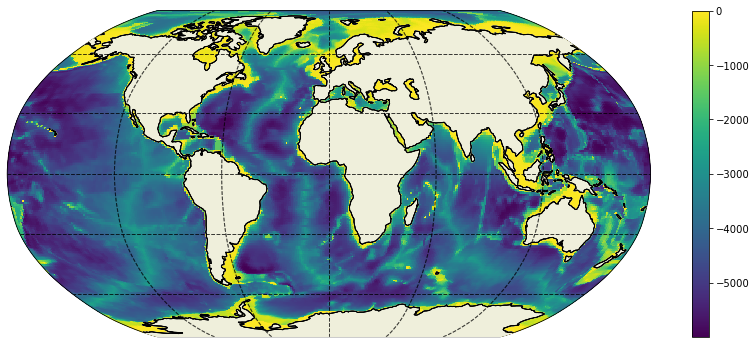

In [8]:
plt.figure(figsize=(15,6));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, bathy, show_colorbar=True);

## Convert the ndarray into a DataArray

Converting the ndarray to a DataArray can be useful for broadcasting operations.

In [9]:
tile = range(1,14)
i = range(90)
j = range(90)

In [10]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
bathy_DA = xr.DataArray(bathy,coords={'tile': tile,
                                         'j': j,
                                         'i': i},dims=['tile','j','i'])

In [11]:
print(bathy_DA.dims)

('tile', 'j', 'i')


## Example 2: Load a 3D 'compact' llc binary file with 3rd dimension = Time


Runoff is a 12 month climatology, dimensions of [time, j, i]

In [12]:
input_file = 'runoff-2d-Fekete-1deg-mon-V4-SMOOTH.bin'

specify the length of the n_recs dimension, nl, as 12. By default, nk = 1

In [13]:
runoff = ecco.read_llc_to_tiles(input_dir, input_file, nl=12)

loading  runoff-2d-Fekete-1deg-mon-V4-SMOOTH.bin
data shape  (12, 1, 1170, 90)
dims, num_dims, llc  (12, 1, 1170, 90) 4 90
4 dimensions
nl, nk  12 1
f5 shape  (12, 1, 90, 270)
data_tiles shape  (12, 1, 13, 90, 90)
data_tiles shape =  (12, 1, 13, 90, 90)


In [14]:
print(runoff.shape)

(12, 1, 13, 90, 90)


### Plot the November runoff climatology

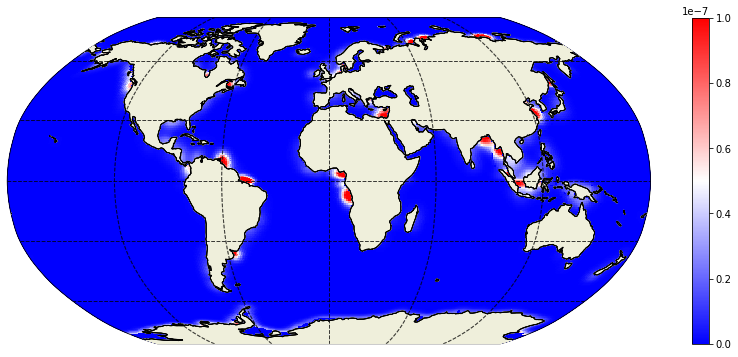

In [15]:
plt.figure(figsize=(15,6));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, runoff[10,:], cmin=0,cmax=1e-7,\
                              show_colorbar=True, cmap='bwr');

## Convert the ndarray into a DataArray

Converting the ndarray to a DataArray can be useful for broadcasting operations.

In [16]:
tile = range(1,14)
i = range(90)
j = range(90)
month = range(12)
k = [0];

In [17]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
runoff_DA = xr.DataArray(runoff,coords={'month': month,
                                        'k': k,
                                        'tile': tile,
                                        'j': j,
                                        'i': i},dims=['month','k','tile','j','i'])

In [18]:
runoff_DA.dims

('month', 'k', 'tile', 'j', 'i')

In [19]:
runoff_DA.shape

(12, 1, 13, 90, 90)

## Example 3: Load a 3D 'compact' llc binary file with 3rd dimension = Depth


'totak_kapredi' is a 50 depth level field of the adjusted GM redi parameter, dimensions of [depth, j, i]

In [20]:
input_file = 'total_kapredi_r009bit11.bin'

specify the number of depth levels as 50.

In [21]:
kapredi = ecco.read_llc_to_tiles(input_dir, input_file, nk=50)

loading  total_kapredi_r009bit11.bin
data shape  (50, 1170, 90)
dims, num_dims, llc  (50, 1170, 90) 3 90
3 dimensions
nk  50
f3 shape  (50, 90, 90)
f5 shape  (50, 90, 270)
3D, data_compact shape  (50, 1170, 90)
data_tiles shape  (50, 13, 90, 90)
data_tiles shape =  (50, 13, 90, 90)


In [22]:
print(kapredi.shape)

(50, 13, 90, 90)


### Plot log10 of the parameter at the 10th depth level (105m)

<ipython-input-23-b09b1aa1ac7e>:2: RuntimeWarning: divide by zero encountered in log10
  ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, np.log10(kapredi[10,:]),\


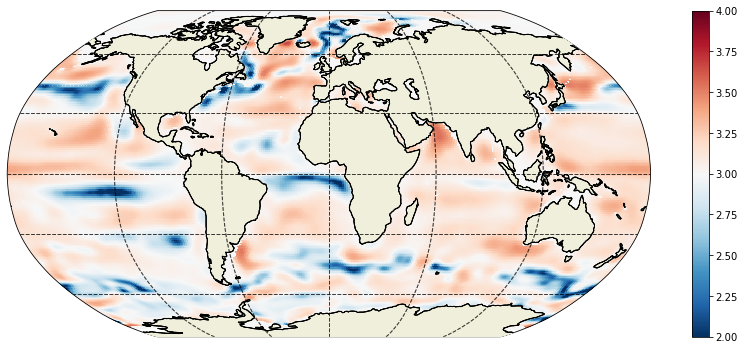

In [23]:
plt.figure(figsize=(15,6));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, np.log10(kapredi[10,:]),\
                              cmin=2,cmax=4,show_colorbar=True);

## Convert the ndarray into a DataArray

Converting the ndarray to a DataArray can be useful for broadcasting operations.

In [24]:
tile = range(1,14)
i = range(90)
j = range(90)
k = range(50)

In [25]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
kapredi_DA = xr.DataArray(kapredi,coords={'k': k,
                                          'tile': tile,
                                          'j': j,
                                          'i': i},dims=['k','tile','j','i'])

In [26]:
kapredi_DA.dims

('k', 'tile', 'j', 'i')

In [27]:
kapredi_DA.shape

(50, 13, 90, 90)

## Parting thoughts

*read_llc_to_tiles* can also be used to read ECCO '*.data'* generated when re-running the ECCO model.